In [10]:
from __future__ import division

import ctypes
import ctypes.util
import datetime
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline

In [2]:
fname = 'rbspa_ect-hope-sci-L3tagged_20150101_v1.0.0.cdf'

In [3]:
d = dm.fromCDF(fname)

In [4]:
d.tree(verbose=1)

+
|____B_Calc_Ele (spacepy.pycdf.VarCopy (0,))
|____B_Calc_Ion (spacepy.pycdf.VarCopy (0,))
|____B_Eq_Ele (spacepy.pycdf.VarCopy (0,))
|____B_Eq_Ion (spacepy.pycdf.VarCopy (0,))
|____Counts_E (spacepy.pycdf.VarCopy (4143, 5, 16, 72))
|____Counts_H (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____Counts_He (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____Counts_O (spacepy.pycdf.VarCopy (3469, 5, 16, 72))
|____ENERGY_Ele_DELTA (spacepy.pycdf.VarCopy (4143, 72))
|____ENERGY_Ion_DELTA (spacepy.pycdf.VarCopy (3469, 72))
|____Ele_SAMPLES (spacepy.pycdf.VarCopy (0, 5, 16, 72))
|____Energy_LABL (spacepy.pycdf.VarCopy (72,))
|____Epoch_Ele (spacepy.pycdf.VarCopy (4143,))
|____Epoch_Ele_DELTA (spacepy.pycdf.VarCopy (4143,))
|____Epoch_Ele_Full (spacepy.pycdf.VarCopy (4143, 16, 72))
|____Epoch_Ion (spacepy.pycdf.VarCopy (3469,))
|____Epoch_Ion_DELTA (spacepy.pycdf.VarCopy (3469,))
|____Epoch_Ion_Full (spacepy.pycdf.VarCopy (3469, 16, 72))
|____FEDU (spacepy.pycdf.VarCopy (4143, 5, 16, 72))
|____FHEDU

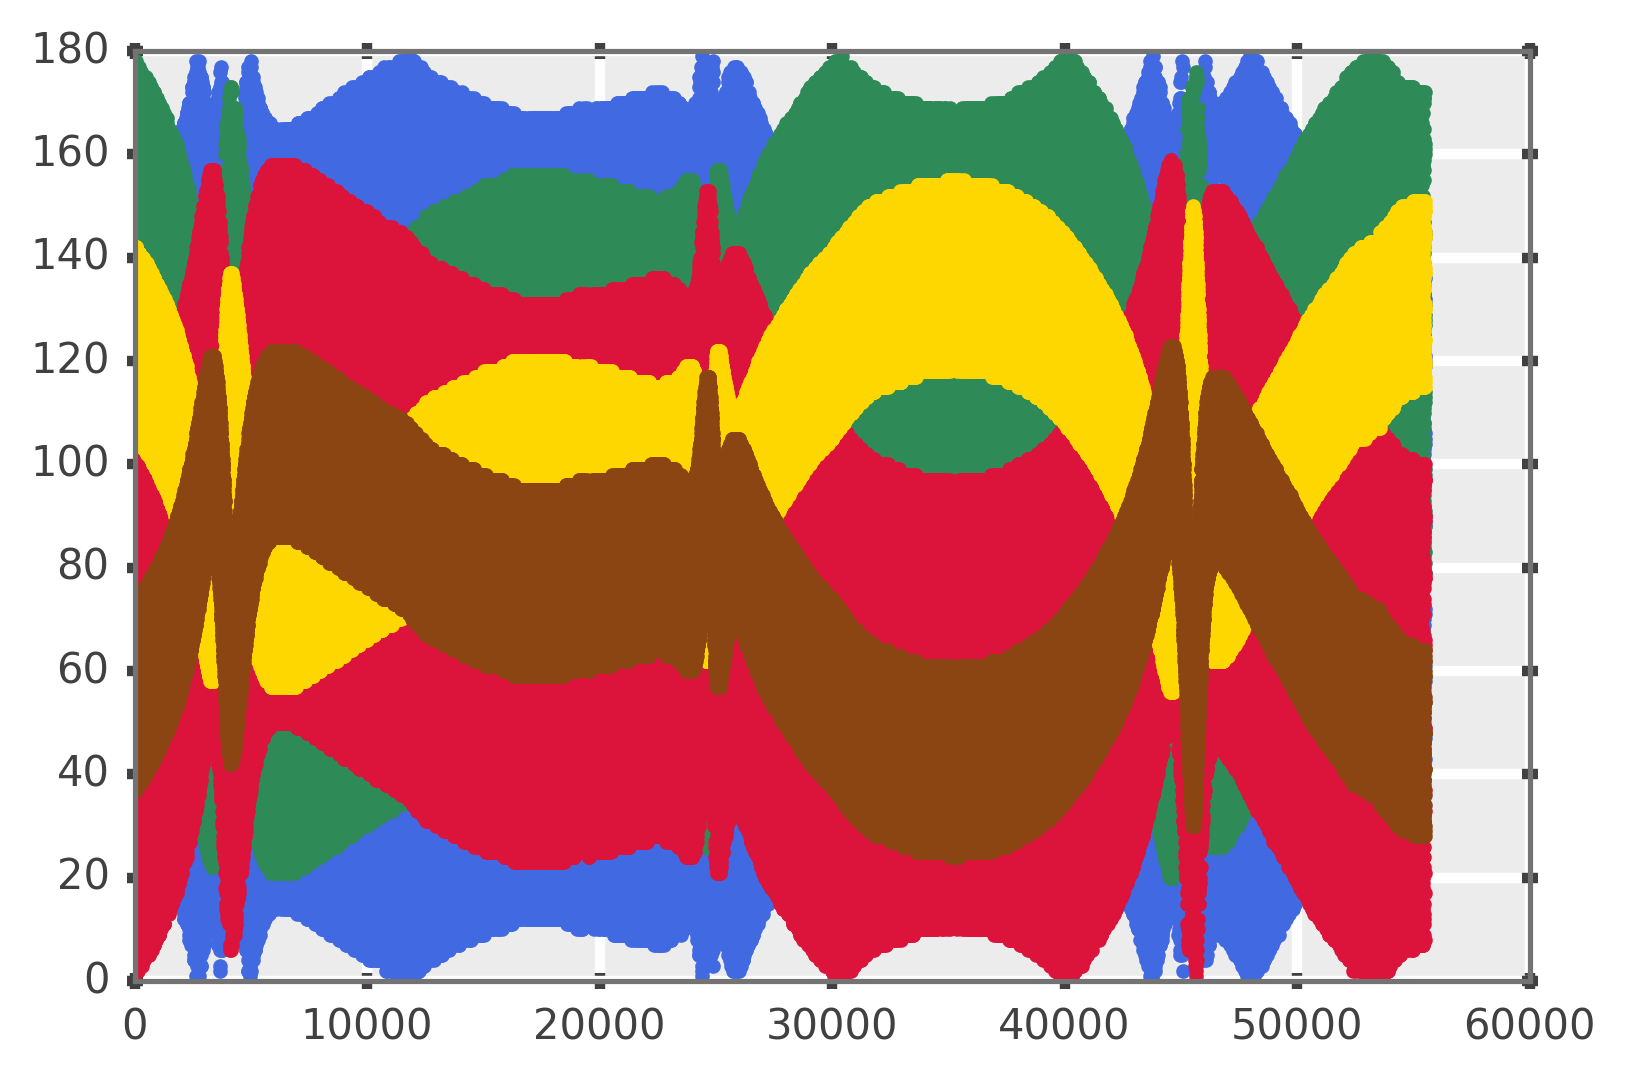

In [5]:
plt.plot(d['PA_Ion'][:,2,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,1,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,3,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,0,:,50].flatten(),'.')
plt.plot(d['PA_Ion'][:,4,:,50].flatten(),'.')


# Split up into a few PA, gyro bins and see about matching up

In [7]:
PA_bins = np.linspace(0, 180, 8)
print(PA_bins)
PHI_bins = np.linspace(0, 360, 5)
print(PHI_bins)

[   0.           25.71428571   51.42857143   77.14285714  102.85714286
  128.57142857  154.28571429  180.        ]
[   0.   90.  180.  270.  360.]


In [11]:
PA_digs0 = np.digitize(d['PA_Ion'][:, 0, :, 70], PA_bins)
print(PA_digs0.shape, PA_digs0.min(), PA_digs0.max(), len(PA_bins))
PA_digs1 = np.digitize(d['PA_Ion'][:, 1, :, 70], PA_bins)
print(PA_digs1.shape, PA_digs1.min(), PA_digs1.max(), len(PA_bins))
PA_digs2 = np.digitize(d['PA_Ion'][:, 2, :, 70], PA_bins)
print(PA_digs2.shape, PA_digs2.min(), PA_digs2.max(), len(PA_bins))
PA_digs3 = np.digitize(d['PA_Ion'][:, 3, :, 70], PA_bins)
print(PA_digs3.shape, PA_digs3.min(), PA_digs3.max(), len(PA_bins))
PA_digs4 = np.digitize(d['PA_Ion'][:, 4, :, 70], PA_bins)
print(PA_digs4.shape, PA_digs4.min(), PA_digs4.max(), len(PA_bins))

PHI_digs0 = np.digitize(d['PHI_Ion'][:, 0, :, 70], PHI_bins)
print(PHI_digs0.shape, PHI_digs0.min(), PHI_digs0.max(), len(PHI_bins))
PHI_digs1 = np.digitize(d['PHI_Ion'][:, 1, :, 70], PHI_bins)
print(PHI_digs1.shape, PHI_digs1.min(), PHI_digs1.max(), len(PHI_bins))
PHI_digs2 = np.digitize(d['PHI_Ion'][:, 2, :, 70], PHI_bins)
print(PHI_digs2.shape, PHI_digs2.min(), PHI_digs2.max(), len(PHI_bins))
PHI_digs3 = np.digitize(d['PHI_Ion'][:, 3, :, 70], PHI_bins)
print(PHI_digs3.shape, PHI_digs3.min(), PHI_digs3.max(), len(PHI_bins))
PHI_digs4 = np.digitize(d['PHI_Ion'][:, 4, :, 70], PHI_bins)
print(PHI_digs4.shape, PHI_digs4.min(), PHI_digs4.max(), len(PHI_bins))


((3469, 16), 3, 7, 8)
((3469, 16), 1, 7, 8)
((3469, 16), 1, 7, 8)
((3469, 16), 1, 7, 8)
((3469, 16), 1, 5, 8)
((3469, 16), 3, 4, 5)
((3469, 16), 1, 4, 5)
((3469, 16), 1, 4, 5)
((3469, 16), 1, 4, 5)
((3469, 16), 1, 2, 5)


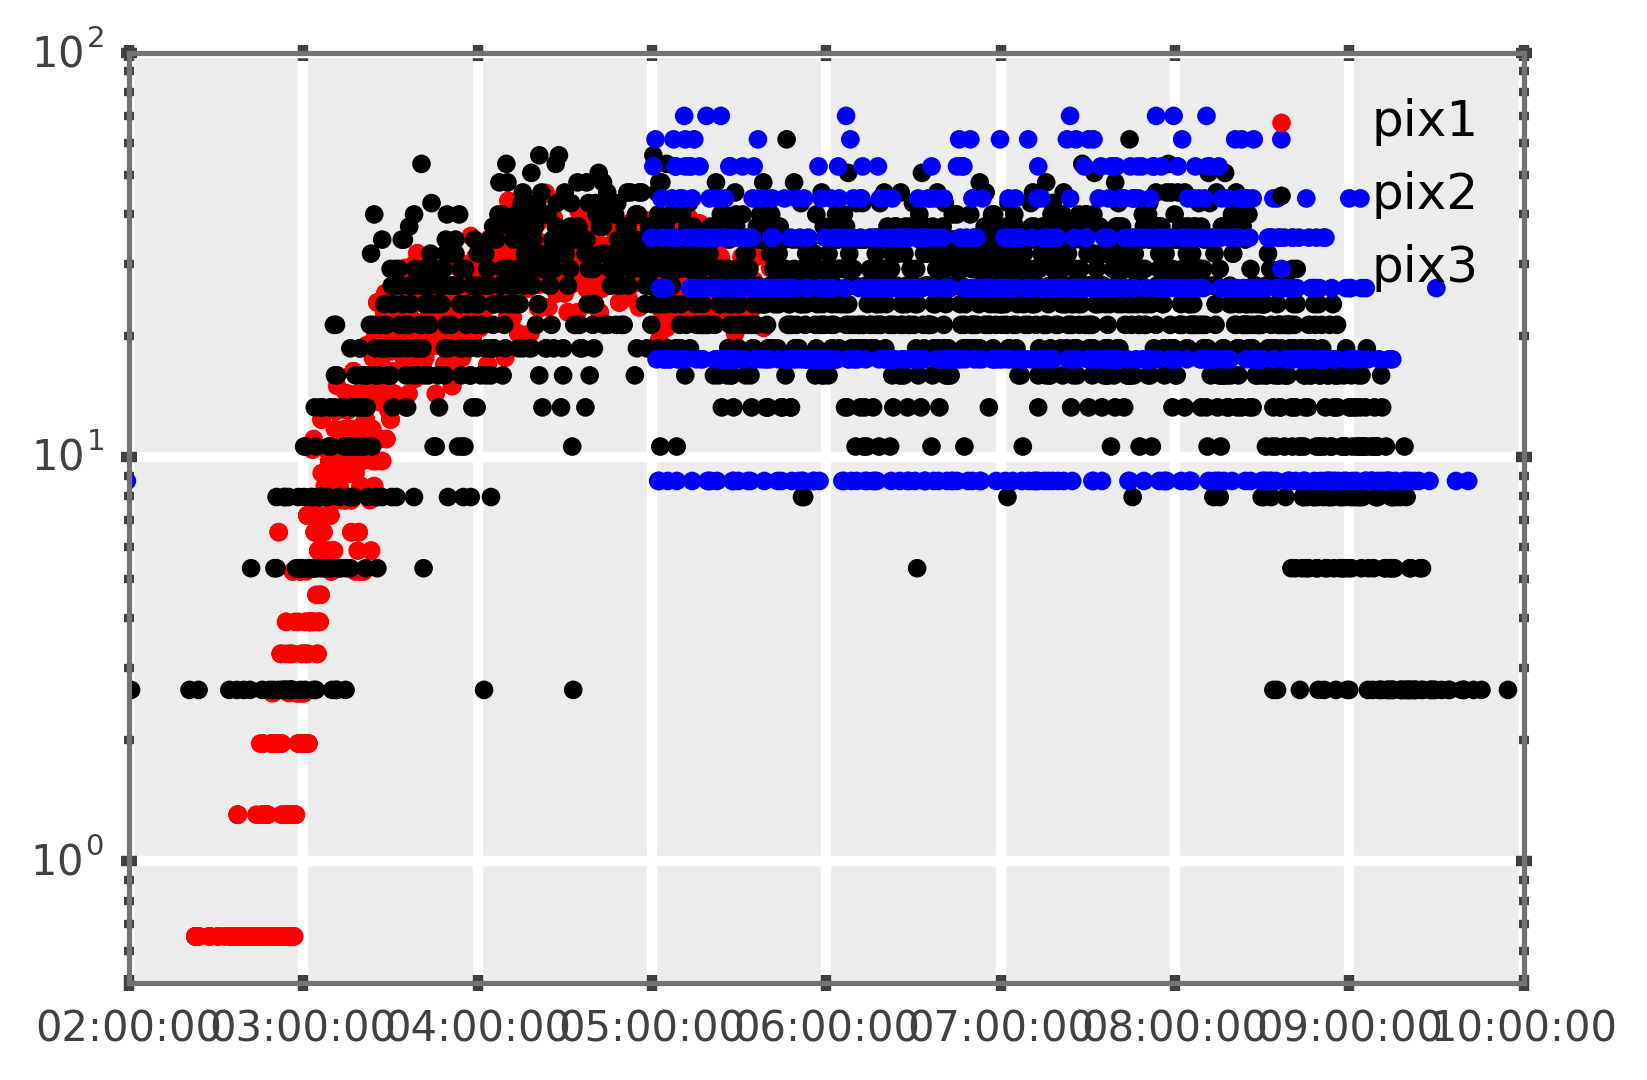

In [12]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')


# plt.semilogy(tt0.UTC, bdat0)
# plt.semilogy(tt1.UTC, bdat1)
# plt.semilogy(tt2.UTC, bdat2)
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)


plt.scatter(tt0.UTC, bdat0, c='r', label='pix1')
plt.scatter(tt1.UTC, bdat1, c='k', label='pix2')
plt.scatter(tt2.UTC, bdat2, c='b', label='pix3')
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))

plt.legend()


## smooth in time

(2, 252)
(2, 283)
(2, 288)
(2, 252)
(2, 283)
(2, 288)


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: divide by zero encountered in float_scalars


/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


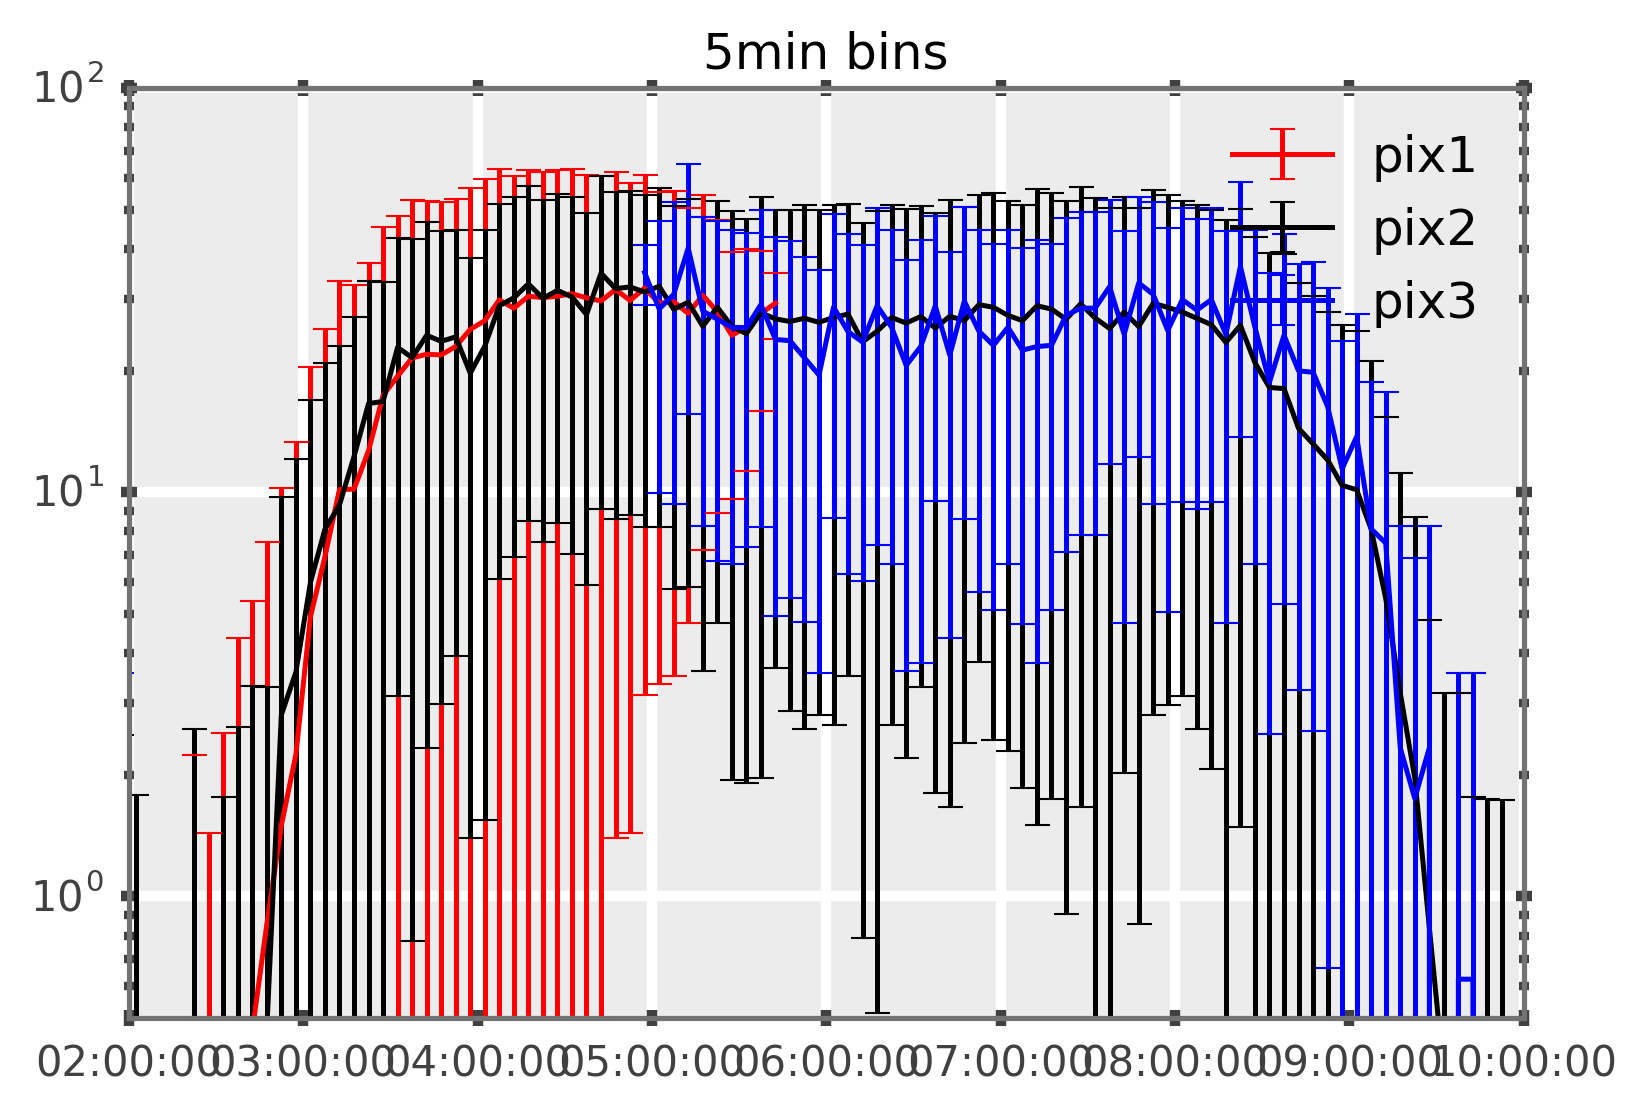

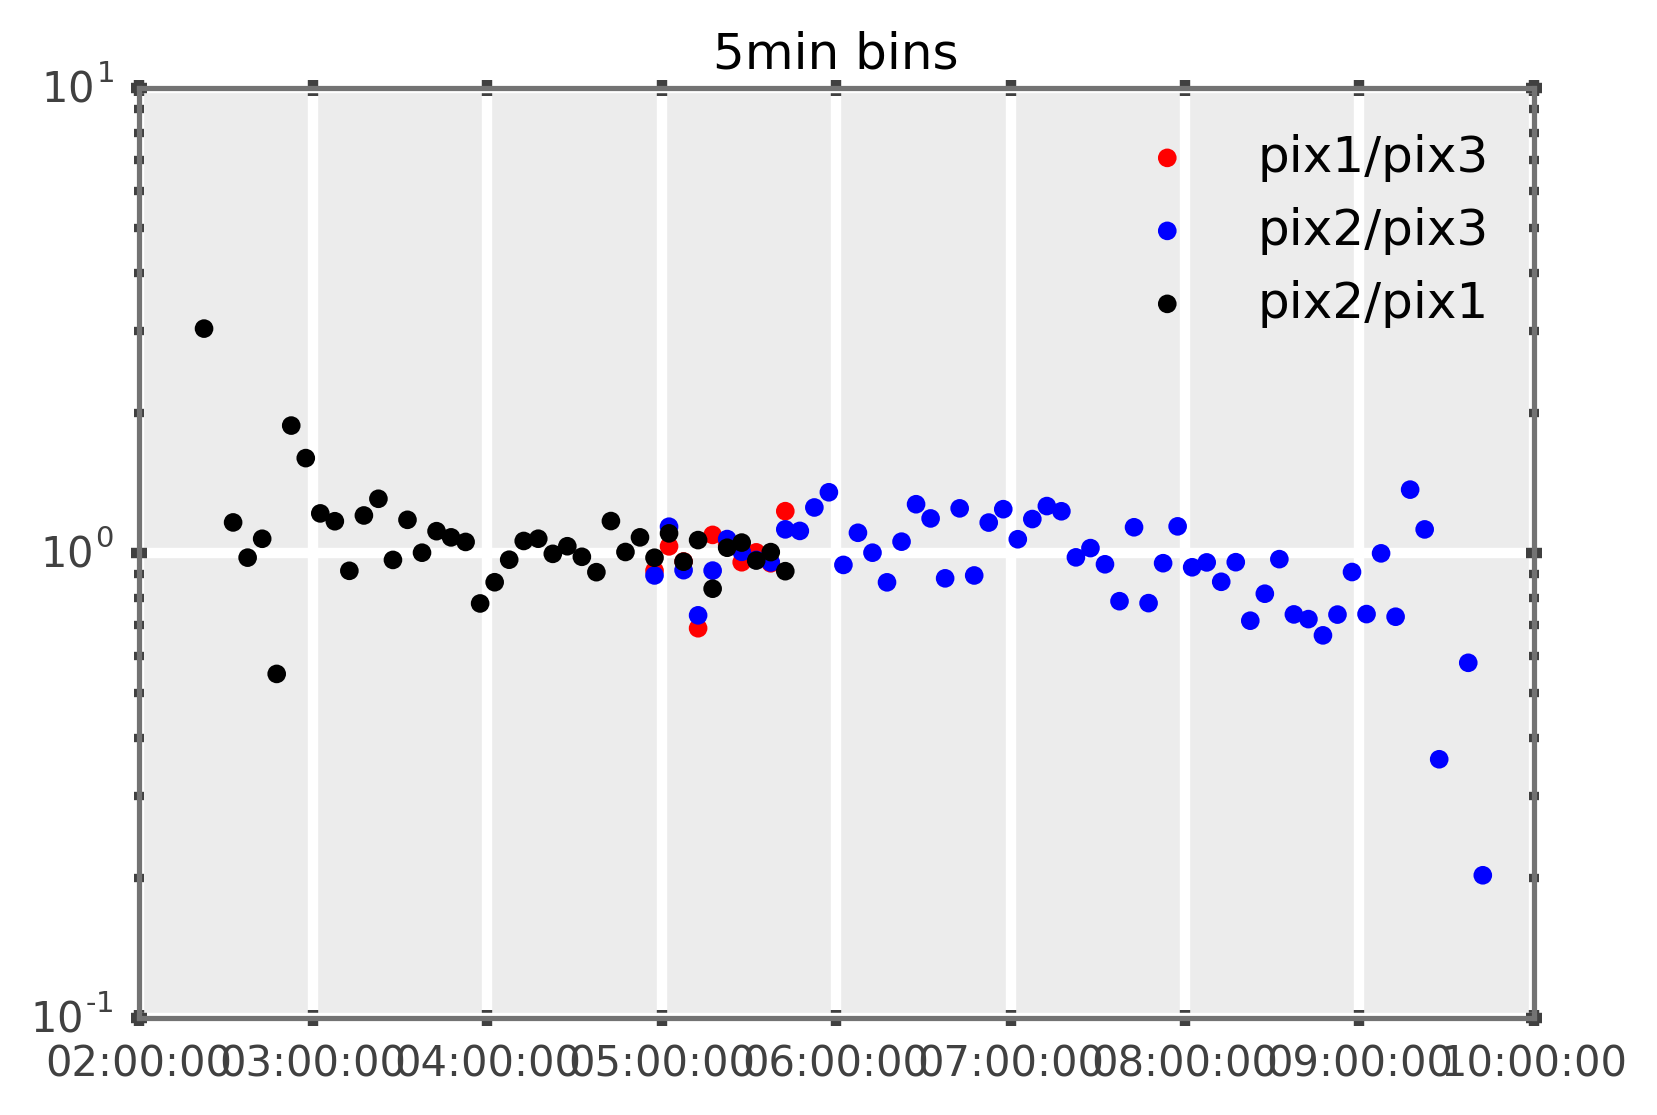

In [20]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=5)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

wms0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm0.shape)
wms1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm1.shape)
wms2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm2.shape)

# plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
# plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
# plt.scatter(wm2[1], wm2[0], c='b', label='pix3')
plt.errorbar(wm0[1], wm0[0], np.sqrt(wms0[0].astype(float)), c='r', label='pix1')
plt.errorbar(wm1[1], wm1[0], np.sqrt(wms1[0].astype(float)), c='k', label='pix2')
plt.errorbar(wm2[1], wm2[0], np.sqrt(wms2[0].astype(float)), c='b', label='pix3')


# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,10)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((.1, 10))
plt.title('5min bins')

plt.legend()



(2, 252)
(2, 283)
(2, 288)
(2, 252)
(2, 283)
(2, 288)
(array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:91: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:91: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:95: RuntimeWarning: invalid value encountered in float_scalars
/Users/blarsen/miniconda3/envs/

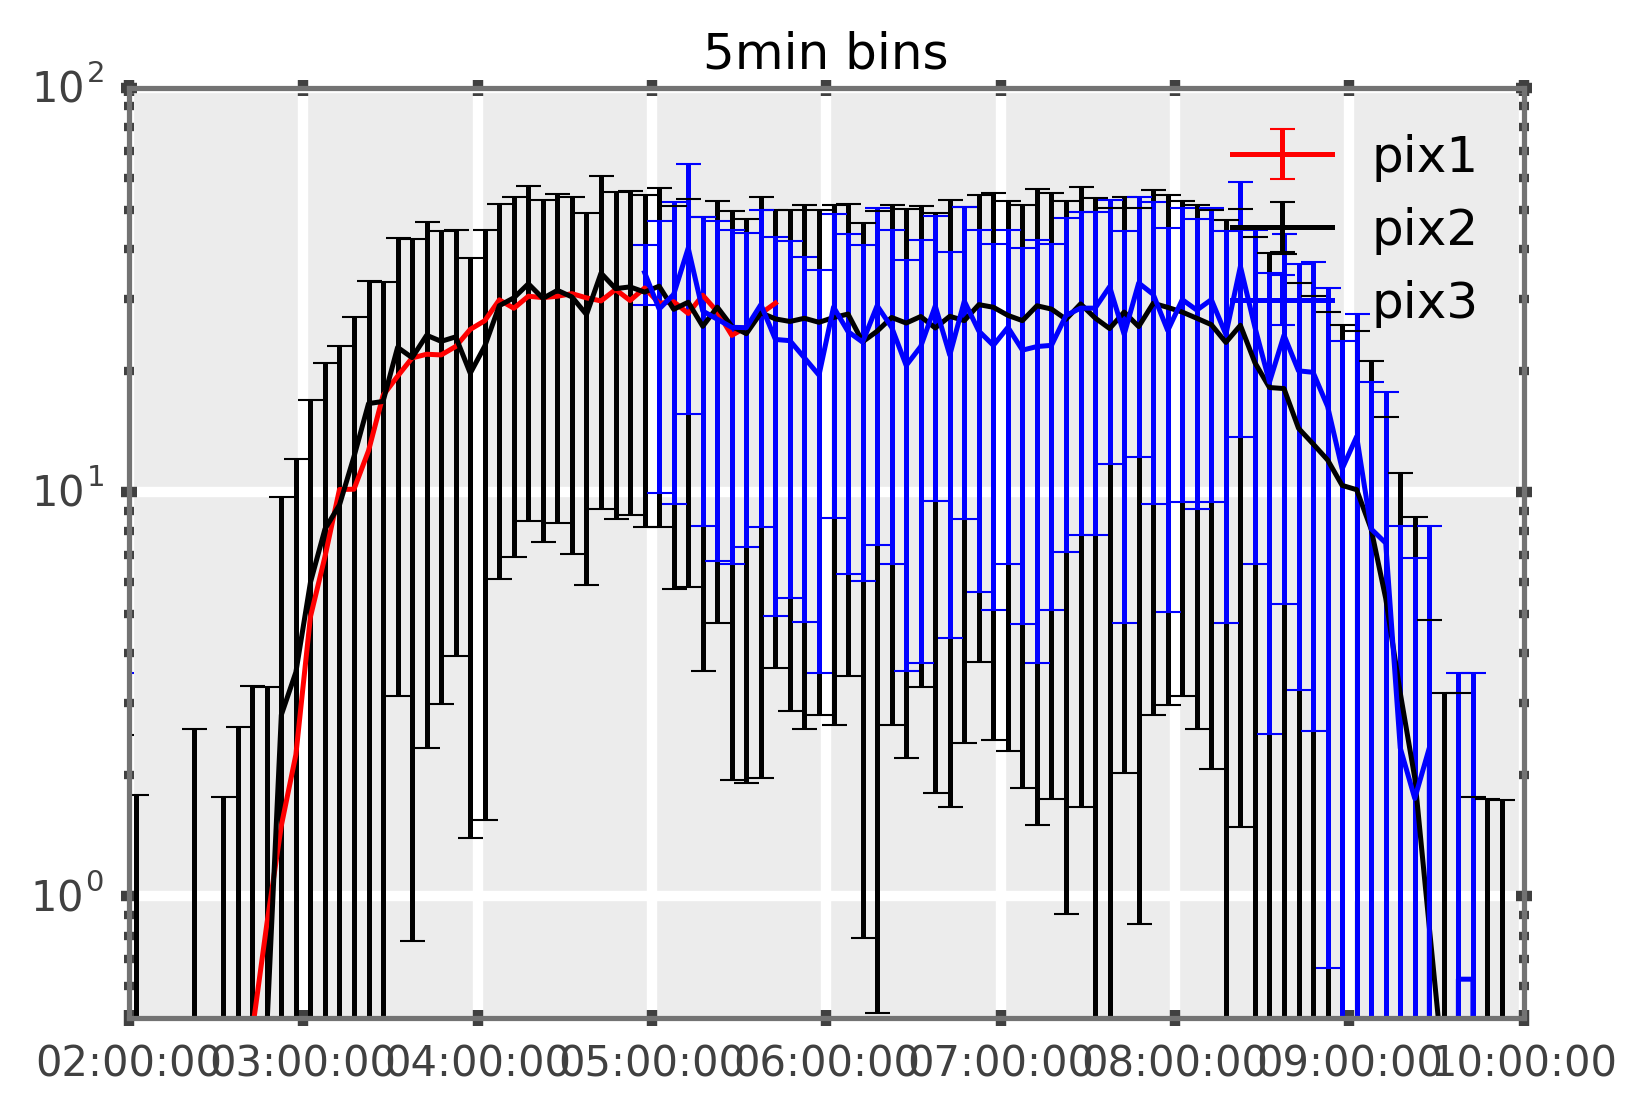

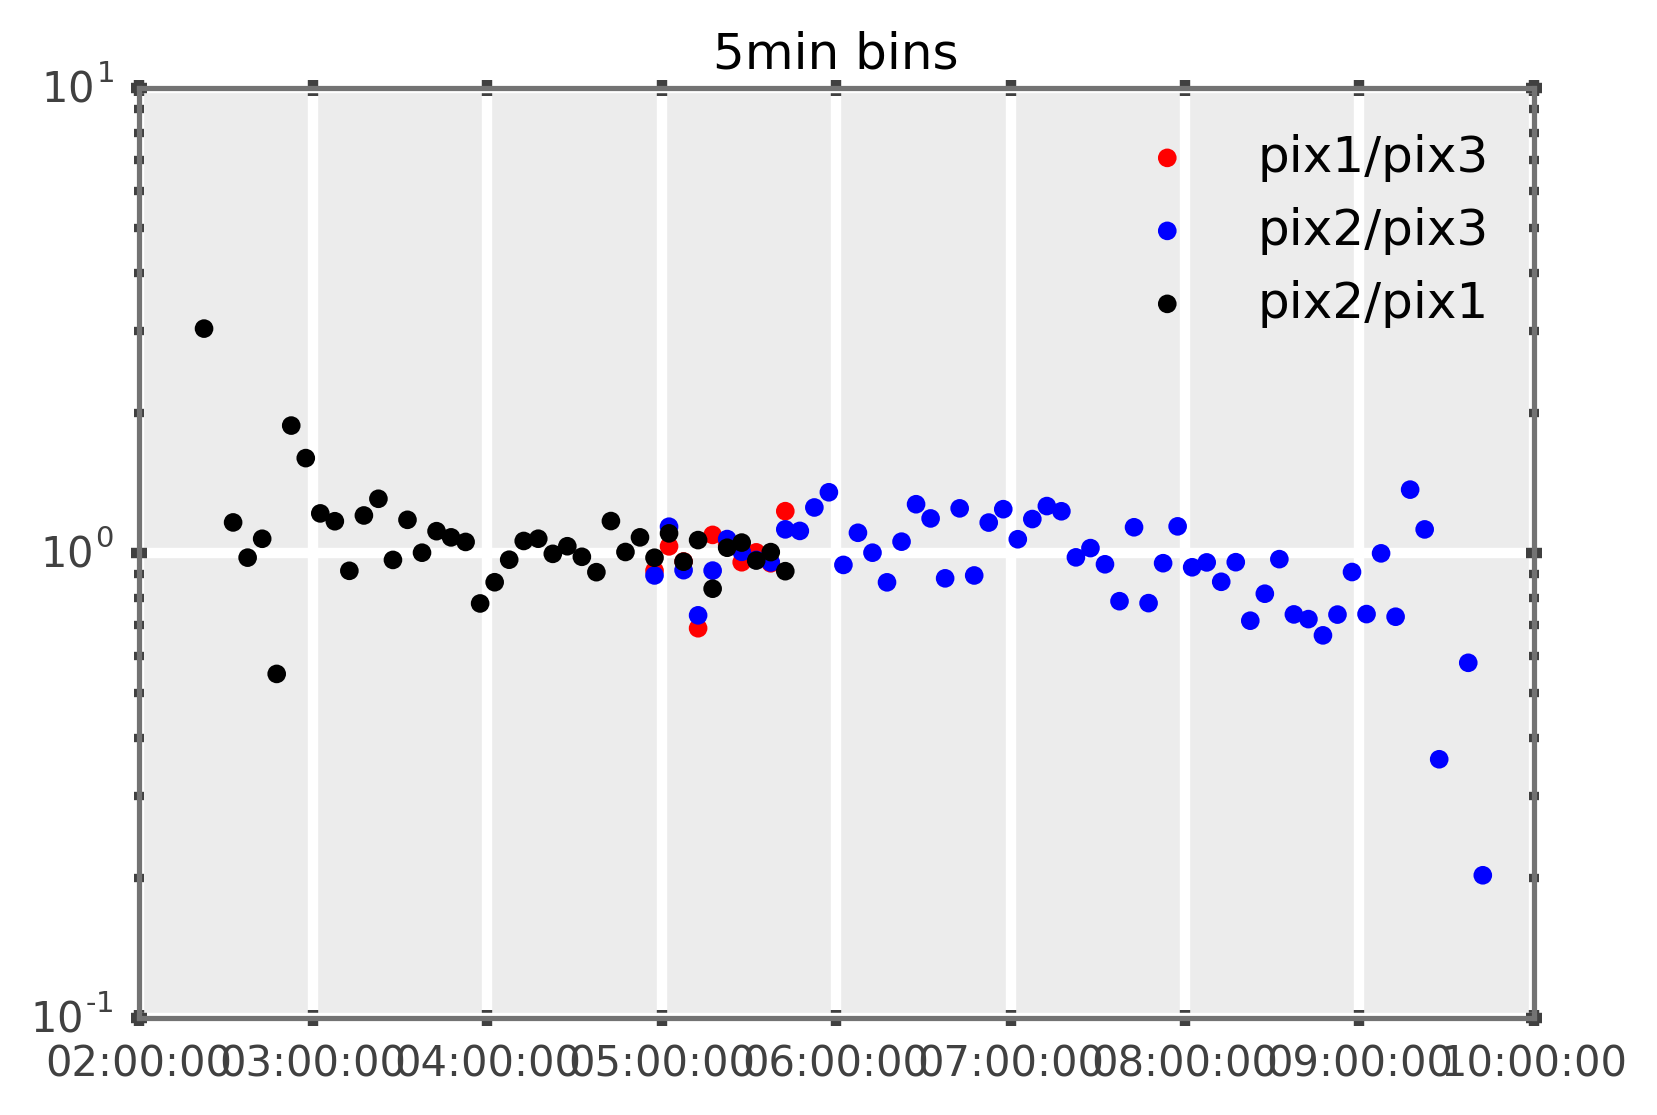

In [33]:
err = dm.fromHDF5('../Poisson.h5')

# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=5)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

wms0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm0.shape)
wms1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm1.shape)
wms2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time, op=np.sum))
print(wm2.shape)

# plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
# plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
# plt.scatter(wm2[1], wm2[0], c='b', label='pix3')

err0 = []
for i in wms0[0]:
    try:
        err0.append(err['value'][i][3,5])
    except (KeyError, IndexError):
        err0.append(np.nan)
err0 = np.asarray(err0)
print(err0, err0.shape)
        
plt.errorbar(wm0[1], wm0[0], err0, c='r', label='pix1')
plt.errorbar(wm1[1], wm1[0], np.sqrt(wms1[0].astype(float)), c='k', label='pix2')
plt.errorbar(wm2[1], wm2[0], np.sqrt(wms2[0].astype(float)), c='b', label='pix3')


# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,10)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,10)))
plt.ylim((.1, 10))
plt.title('5min bins')

plt.legend()



In [17]:
wms0[0]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,
       0.65215319, 0.0, 3.260766, 3.2608001, 2.6086128, 0.0, 0.0, nan, nan,
       nan, nan, 0.0, 0.0, 0.0, 0.0, 4.5650725, 1.9564595, 5.8693786,
       16.303898, 24.129684, 44.34708, 76.30526, 123.2632, 240.67036,
       339.16693, 538.13489, 498.3504, 582.52808, 780.90802, 832.46716,
       988.43964, 943.43036, 917.97913, 917.35352, 985.89838, 1089.0262,
       1106.7141, 1026.4351, 1038.207, 999.71417, 1038.2068, 1022.5627,
       937.70947, 951.39941, 920.11835, 804.58386, 832.02753, 674.7218,
       680.60034, 525.92719, 552.7132, 363.45169, 219.88153, 204.88336,
       138.33385, 29.363806, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, 6.5215659, 5.217225

In [ ]:
# split out the counts data for a particular bin
PA_digs0.shape, d['Counts_H'][:,0,:,70].shape

bdat0 = d['Counts_H'][:,0,:,70][(PA_digs0==3) & (PHI_digs0==3)]
bdat1 = d['Counts_H'][:,1,:,70][(PA_digs1==3) & (PHI_digs1==3)]
bdat2 = d['Counts_H'][:,2,:,70][(PA_digs2==3) & (PHI_digs2==3)]
bdat3 = d['Counts_H'][:,3,:,70][(PA_digs3==3) & (PHI_digs3==3)]
bdat4 = d['Counts_H'][:,4,:,70][(PA_digs4==3) & (PHI_digs4==3)]
tt0 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs0==3) & (PHI_digs0==3)], 'CDF')
tt1 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs1==3) & (PHI_digs1==3)], 'CDF')
tt2 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs2==3) & (PHI_digs2==3)], 'CDF')
# tt3 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs3==3) & (PHI_digs3==3)], 'CDF')
# tt4 = spt.Ticktock(d['Epoch_Ion_Full'][:,:,70][(PA_digs4==3) & (PHI_digs4==3)], 'CDF')

# tb.windowMean(data, time=[], winsize=0, overlap=0, st_time=None, op=<function mean at 0x1094d7488>)

st_time=datetime.datetime(2015,1,1)
tdel = datetime.timedelta(minutes=30)

wm0 = np.asarray(tb.windowMean(bdat0, time=tt0.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm0.shape)
wm1 = np.asarray(tb.windowMean(bdat1, time=tt1.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm1.shape)
wm2 = np.asarray(tb.windowMean(bdat2, time=tt2.UTC, 
                    winsize=tdel, 
                   overlap=datetime.timedelta(minutes=0), 
                              st_time=st_time))
print(wm2.shape)

plt.scatter(wm0[1], wm0[0], c='r', label='pix1')
plt.scatter(wm1[1], wm1[0], c='k', label='pix2')
plt.scatter(wm2[1], wm2[0], c='b', label='pix3')
# plt.semilogy(tt3.UTC, bdat3)
# plt.semilogy(tt4.UTC, bdat4)

plt.yscale('log')
plt.xlim((datetime.datetime(2015,1,1,2), 
          datetime.datetime(2015,1,1,23,59)))
plt.ylim((1/2, 100))
plt.title('5min bins')
plt.legend()


# to do ratios we have to trim the end time to the region of interest
e_time = datetime.datetime(2015,1,1,20)
ind0 = wm0[1] <= e_time
ind1 = wm1[1] <= e_time
ind2 = wm2[1] <= e_time


plt.figure()
plt.scatter(wm0[1][ind0], wm0[0][ind0]/wm2[0][ind2], 
            c='r', label='pix1/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm2[0][ind2], 
            c='b', label='pix2/pix3')
plt.scatter(wm1[1][ind1], wm1[0][ind1]/wm0[0][ind0], 
            c='k', label='pix2/pix1')

plt.yscale('linear')
plt.xlim((datetime.datetime(2015,1,1,0), 
          datetime.datetime(2015,1,1,23,59)))
plt.ylim((0, 2.5))
plt.title('30min bins')

plt.legend()



In [ ]:
tb.windowMean?

In [ ]:
plt.errorbar?